# 训练深层神经网络

1. 梯度消失
2. 训练缓慢
3. 过拟合

### 在梯度消失的问题上：我们需要每层输出的方差等于其输入的方差。
### 1. 使用参数初始化技巧

![参数初始化](./images/参数初始化.PNG)

In [1]:
import tensorflow as tf

>he_init = _tf.contrib.layers.variance_scaling_initializer()

>hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,kernel_initializer=he_init, name="hidden1")


### 2. 选取非饱和激活函数 

$ LeakyReLU \alpha(z) = max(az, z)$

通常设置a = 0.01  but有时候a=0.2似乎比较好

## 选取指数线性单元ELU

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

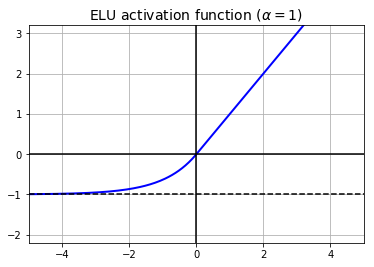

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("elu_plot")
plt.show()

$ELU_{a} = \left\{\begin{matrix}a(exp(z)-1) & if z<0  \\  z & if z\geq 0 \end{matrix}\right.$
##### 指数线性单元


$SELU_{a} =scale * elu(z, alpha)$
##### 缩放型指数线性单元

理论上首先使用 SELU>ELU> leaky ReLU（及其变体）> ReLU > tanh > sigmoid
1. 如果关心运行时性能 ->leak ReLU
2. 如果神经网络过拟合->RReLU
3. 如果有庞大的训练数据集->PReLU(a被授权在训练过程中学习)

## 选取缩放型指数线性单元SELU

In [5]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

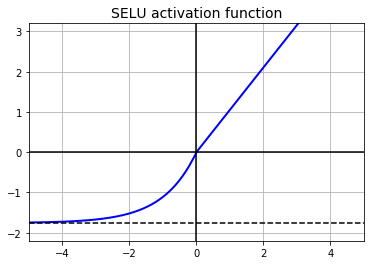

In [6]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("selu_plot")
plt.show()

In [7]:
import tensorflow as tf
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y= tf.placeholder(tf.int64,shape=(None),name="y")

def neuron_layer(X,n_neuron,name,activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2/np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs,n_neuron),stddev=stddev)
        w = tf.Variable(init,name="wegihts")
        b = tf.Variable(tf.zeros([n_neuron]),name="biases")
        z = tf.matmul(X,w)+b
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z

from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X,n_hidden1,"hidden1",activation="relu")
    hidden2 = neuron_layer(hidden1,n_hidden2,"hidden2",activation="relu")
    logits = neuron_layer(hidden2,n_outputs,"output")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")



learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

accuracy_summary = tf.summary.scalar('accuracy', accuracy)
loss_summary = tf.summary.scalar('loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# 执行阶段

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

n_epochs = 40
batch_size = 50
n_batches = len(X_train)//batch_size

def shuffle_data(X,y,epoch,batch_size,batch_index):
    np.random.seed(epoch*n_batches + batch_index)
    random_index = np.random.randint(len(X_train),size=batch_size)
    X_batch = X[random_index]
    y_batch = y[random_index]
    return X_batch,y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch,y_batch = shuffle_data(X_train,y_train,epoch,batch_size,batch_index)
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
            if batch_index % 10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
        summary_str = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
        step = epoch
        file_writer.add_summary(summary_str, step)
        acc_train = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test,y:y_test})
        file_writer.add_summary(accuracy_summary.eval(feed_dict={X: X_test,y:y_test}), step)
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    save_path = saver.save(sess, "./tmp/my_model_final.ckpt")
file_writer.close()

with tf.Session() as sess:
    saver.restore(sess, "./tmp/my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)                 

print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

0 Train accuracy: 0.9 Test accuracy: 0.9132
1 Train accuracy: 0.94 Test accuracy: 0.9305
2 Train accuracy: 0.96 Test accuracy: 0.9372
3 Train accuracy: 0.94 Test accuracy: 0.9458
4 Train accuracy: 0.98 Test accuracy: 0.9485
5 Train accuracy: 0.98 Test accuracy: 0.952
6 Train accuracy: 1.0 Test accuracy: 0.9557
7 Train accuracy: 0.96 Test accuracy: 0.9579
8 Train accuracy: 0.92 Test accuracy: 0.9601
9 Train accuracy: 0.96 Test accuracy: 0.9607
10 Train accuracy: 0.98 Test accuracy: 0.9641
11 Train accuracy: 0.98 Test accuracy: 0.9657
12 Train accuracy: 0.98 Test accuracy: 0.9662
13 Train accuracy: 0.98 Test accuracy: 0.9677
14 Train accuracy: 0.94 Test accuracy: 0.9683
15 Train accuracy: 0.98 Test accuracy: 0.9697
16 Train accuracy: 0.98 Test accuracy: 0.9702
17 Train accuracy: 1.0 Test accuracy: 0.9706
18 Train accuracy: 1.0 Test accuracy: 0.9719
19 Train accuracy: 1.0 Test accuracy: 0.9718
20 Train accuracy: 0.98 Test accuracy: 0.9722
21 Train accuracy: 0.98 Test accuracy: 0.9738
22 T

# 批量标准化BN

1. 每层的激活函数之前在模型中添加操作
2. 简单地对输入进行zero-centering和规范化，然后每层使用4个新参数（一个用于尺度变换，另一个用于偏移）对结果进行尺度变换和偏移  在测试时，使用整个训练集的均值和标准差

In [8]:
from functools import  partial
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [9]:
import numpy as np

In [17]:
tf.reset_default_graph()
  


def shuffle_data(X,y,epoch,batch_size,batch_index):
    np.random.seed(epoch*batch_size+batch_size)
    random_index = np.random.randint(len(X),size=batch_size)
    X_batch = X[random_index]
    y_batch = y[random_index]
    return X_batch,y_batch


if __name__ == '__main__':
    n_inputs = 28*28
    n_hidden1 = 300
    n_hidden2 = 100
    n_outputs = 10
            
    
    n_epochs = 20
    batch_size = 50
    n_batches = len(X_train)//batch_size
    
    
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28)/255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28)/255.0
    y_train = y_train.astype(np.int64)
    y_test = y_test.astype(np.int64)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]

    
    batch_norm_momentum = 0.9
    learning_rate = 0.01
    
    X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
    y = tf.placeholder(tf.int64,shape=(None),name="y")
    training = tf.placeholder_with_default(False,shape=(),name='training')
    
    with tf.name_scope('DNN'):
        he_init = tf.variance_scaling_initializer()  #权重初始化
        
        my_batch_norm_layer = partial(
            tf.layers.batch_normalization,
            training = training,
            momentum = batch_norm_momentum
        )
        
        my_dense_layer = partial(
            tf.layers.dense,
            kernel_initializer = he_init
        )
        
        hidden1 = my_dense_layer(X,n_hidden1,name='hidden1')
        bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
        hidden2 = my_dense_layer(bn1,n_hidden2,name='hidden2')
        bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
        logists_before_bn = my_dense_layer(bn2,n_outputs,name="outputs")
        logists = my_batch_norm_layer(logists_before_bn)
        
    with tf.name_scope('loss'):
        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits=logists)
        loss = tf.reduce_mean(xentropy,name="loss")
        
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(extra_update_ops):
            training_op = optimizer.minimize(loss)
        
    with tf.name_scope('eval'):
        correct = tf.nn.in_top_k(logists,y,1)
        accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [18]:
   with tf.Session() as sess:
        init.run()
        for epoch in range(n_epochs):
            for batch_index in range(n_batches):
                X_batch,y_batch = shuffle_data(X_train,y_train,epoch,batch_size,batch_index)
                sess.run(training_op,feed_dict={training:True,X:X_batch,y:y_batch})
            accuracy_val = accuracy.eval(feed_dict={X: X_test,y:y_test})
            print(epoch,"Test accuracy",accuracy_val)
        save_path = saver.save(sess, "./tmp/my_model_final.ckpt")

0 Test accuracy 0.5062
1 Test accuracy 0.597
2 Test accuracy 0.6328
3 Test accuracy 0.6244
4 Test accuracy 0.6521
5 Test accuracy 0.6935
6 Test accuracy 0.697
7 Test accuracy 0.7342
8 Test accuracy 0.7425
9 Test accuracy 0.7589
10 Test accuracy 0.7418
11 Test accuracy 0.7813
12 Test accuracy 0.7657
13 Test accuracy 0.7775
14 Test accuracy 0.7401
15 Test accuracy 0.7919
16 Test accuracy 0.7581
17 Test accuracy 0.8023
18 Test accuracy 0.8072
19 Test accuracy 0.7973


In [19]:
with tf.Session() as sess:
    saver.restore(sess, "./tmp/my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logists.eval(feed_dict={training:False,X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)  

INFO:tensorflow:Restoring parameters from ./tmp/my_model_final.ckpt


In [20]:
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

Predicted classes: [7 2 1 0 4 1 4 9 9 6 0 8 9 0 1 1 9 7 2 4]
Actual classes:    [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


# 梯度裁剪

```
threshold = 1.0
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)
```

# 复用预训练层

如果输入具有类似的低级层次的特征，则迁移学习将很好地工作

```
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
scope="hidden[123]") # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict) # to restore layers 1-3
```




```
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden3/Relu:0")
```

# 冻结较低层

```
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="hidden[34]|outputs")
training_op = optimizer.minimize(loss,var_list = train_vars)
```

# 缓存冻结层

```
with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) # not shown in the book

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})

        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, # not shown
                                                y: y_valid})             # not shown
        print(epoch, "Validation accuracy:", accuracy_val)               # not shown

```

# 调整，删除或替换较高层

整个思路是:
1. 将模型复制之后，冻结整个复制模型层。
2. 尝试观察输出，并逐层解冻，找到适合新任务的层数。
3. 最后解冻一个或两个较高的隐藏层
4. 如果训练仍无法获得良好的性能，请删除顶部的隐藏层

# Model Zoos

TensorFlow 在 https://github.com/tensorflow/models 中有自己的模型动物园

# 加速训练的方法：
1. 对连接权重应用良好的初始化策略
2. 使用良好的激活函数
3. 使用批量规范化
4. 重用预训练网络的部分
5. 使用更加快速的优化器

#### 更加快速的优化器
1. 动量优化
2. Nesterov 加速梯度
3. AdaGrad
4. RMSProp
5. Adam 优化（默认使用优化器）动量衰减超参数 β1 通常初始化为 0.9，而缩放衰减超参数 β2 通常初始化为 0.999

# 1.训练稀疏模型

#### 使用LI正则化以及正则化领导者FTRL

# 2.Dropout
## Dropconnect是dropout的变体

# 3.L1 和 L2 正则化

# 4.最大范数正则化

对于每个神经元，它约束输入连接的权重 $w$ ，使得$ \left \| w \right \|_{2}\leqslant r$，其中$ r $是最大范数超参数， 是$ l2 $范数。我们通常通过在每个训练步骤之后计算$ \left \| w \right \|_{2}$ 来实现这个约束，并且如果需要的话可以剪切 W 。
$$w\leftarrow w\frac{r}{\left \| w \right \|_{2}}$$


# 5.数据增强

# 6.添加跳过连接（深度残差网络）

![深度神经网络训练注意事项](./images/深度神经网络训练注意事项.PNG)